In [1]:
!pip install -Uqq git+https://github.com/fastai/course22p2

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 11.5 MB/s eta 0:00

# Initialization

In [2]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=2)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [5]:
def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to(def_device)

In [6]:
get_model()

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

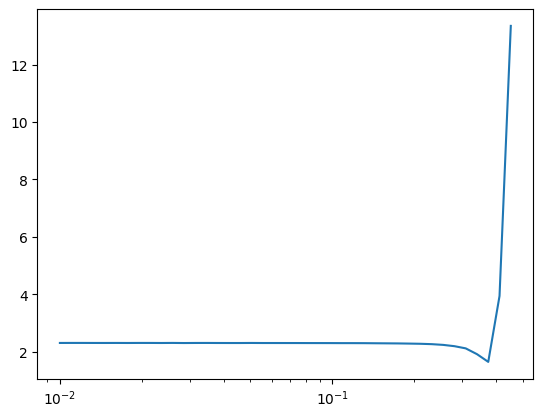

In [7]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [8]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.163,2.419,0,train
0.100,2.306,0,eval


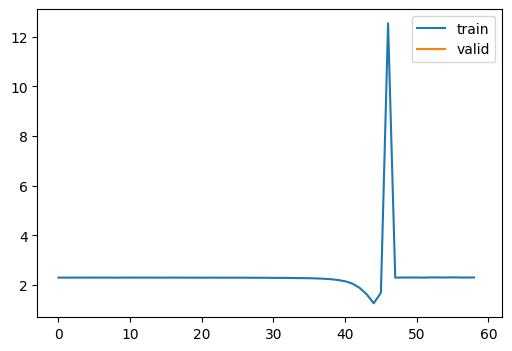

In [9]:
learn.fit(1)

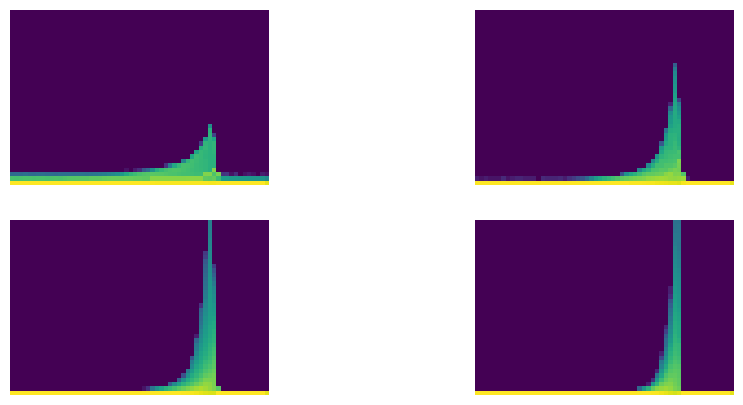

In [10]:
astats.color_dim()

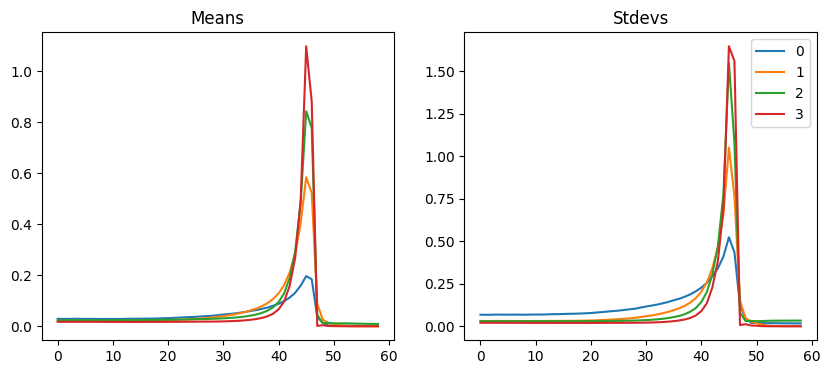

In [11]:
astats.plot_stats()

In [12]:
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [13]:
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [14]:
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

In [15]:
clean_mem()

## Glorot/Xavier init

In [16]:
x = torch.randn(200,100)
for i in range(50): x = x @ torch.randn(100,100)
x[0:5, 0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

In [17]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.01)
x[0:5,0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

So we have to scale our weight matrices exactly right so that the standard deviation of our activations stays at 1.

In [18]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.1)
x[0:5,0:5]

tensor([[ 2.02, -1.99, -0.30, -0.47, -0.15],
        [ 0.83, -1.06,  0.96,  0.18,  0.52],
        [-0.82,  0.73,  0.03, -0.18, -0.42],
        [ 0.29,  0.11,  0.92,  0.77,  0.53],
        [-1.77,  1.57,  0.53, -0.09, -0.66]])

### Background

#### Variance and standard deviation
Variance is the average of how far away each data point is from the mean. E.g.:

In [19]:
t = torch.tensor([1.,2.,4.,18])

In [20]:
m = t.mean(); m

tensor(6.25)

In [21]:
(t-m)

tensor([-5.25, -4.25, -2.25, 11.75])

In [22]:
(t-m).mean()

tensor(0.)

Oops. We can't do that. Because by definition the positives and negatives cancel out. So we can fix that in one of (at least) two ways:

In [23]:
# variance #
(t-m).pow(2).mean()

tensor(47.19)

In [24]:
# mean absolute deviation. #
(t-m).abs().mean()

tensor(5.88)

In [25]:
# standard deviation. #
(t-m).pow(2).mean().sqrt()

tensor(6.87)

In [26]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.19), tensor(47.19))

#### Covariance

In [27]:
t

tensor([ 1.,  2.,  4., 18.])

In [28]:
u = t*2
u *= torch.randn_like(t)/10+0.95
u

tensor([ 1.97,  4.25,  7.16, 33.69])

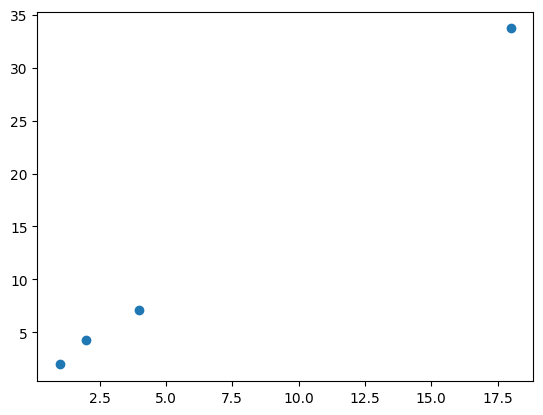

In [29]:
plt.scatter(t,u);

In [30]:
prod = (t-t.mean())*(u-u.mean()); prod

tensor([ 51.43,  31.97,  10.37, 257.63])

In [31]:
prod.mean()

tensor(87.85)

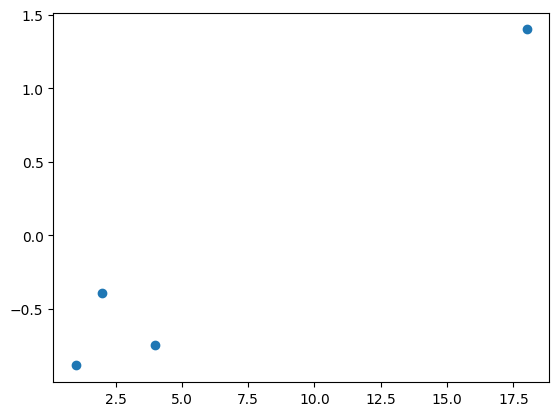

In [32]:
v = torch.randn_like(t)
plt.scatter(t,v);

In [33]:
((t-t.mean())*(v-v.mean())).mean()

tensor(6.11)

It's generally more conveniently defined like so:

E[XY] - E[X]E[Y]

In [34]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(6.11)

Pearson correlation coefficient:

In [35]:
cov / (t.std() * v.std())

tensor(0.73)

In [36]:
x.shape, x.std()

(torch.Size([200, 100]), tensor(1.06))

#### Xavier init derivation

When we do `y = a @ x`, the coefficients of `y` are defined in pure python code:
```python
y[i] = sum([c*d for c,d in zip(a[i], x)])
```
or in numpy/pytorch code:
```python
y[i] = (a[i]*x).sum()
```
At the very beginning, our x vector has a mean of roughly 0. and a standard deviation of roughly 1. (since we picked it that way).



In [37]:
x = torch.randn(100)
x.mean(), x.std()

(tensor(-0.05), tensor(1.12))

If we go back to y = a @ x and assume that we chose weights for a that also have a mean of 0, we can compute the standard deviation of y quite easily. Since it's random, and we may fall on bad numbers, we repeat the operation 100 times.



In [38]:
mean,sqr = 0.,0.
for i in range(100):
    x = torch.randn(100)
    a = torch.randn(512, 100)
    y = a @ x
    mean += y.mean().item()
    sqr  += y.pow(2).mean().item()
mean/100,sqr/100

(0.025048027038574217, 103.18466705322265)

Now that looks very close to the dimension of our matrix 100. And that's no coincidence! When you compute y, you sum 100 product of one element of a by one element of x. So what's the mean and the standard deviation of such a product? We can show mathematically that as long as the elements in a and the elements in x are independent, the mean is 0 and the std is 1. This can also be seen experimentally:

In [39]:
mean,sqr = 0.,0.
for i in range(10000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a*x
    mean += y.item()
    sqr  += y.pow(2).item()
mean/10000,sqr/10000

(0.0011300370094810205, 0.9872757379214853)

Then we sum 100 of those things that have a mean of zero, and a mean of squares of 1, so we get something that has a mean of 0, and mean of square of 100, hence math.sqrt(100) being our magic number. If we scale the weights of the matrix and divide them by this math.sqrt(100), it will give us a y of scale 1, and repeating the product has many times as we want won't overflow or vanish.

## Kaiming/He init
("He" is a Chinese surname and is pronouced like "Her", not like "Hee".)

**Background**

In [40]:
x = torch.randn(200, 100)
y = torch.randn(200)

In [41]:
from math import sqrt

In [42]:
w1 = torch.randn(100,50) / sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1) / sqrt(50)
b2 = torch.zeros(1)

In [43]:
def lin(x, w, b): return x @ w + b

In [44]:
x.shape, w1.shape

(torch.Size([200, 100]), torch.Size([100, 50]))

In [45]:
l1 = lin(x, w1, b1)
l1.mean(), l1.std()

(tensor(0.00), tensor(1.02))

In [46]:
def relu(x): return x.clamp_min(0.)

In [47]:
l2 = relu(l1)
l2.mean(), l2.std()

(tensor(0.41), tensor(0.60))

In [48]:
x = torch.randn(200,100)
for i in range(50): x = relu(x @ (torch.randn(100,100)*0.1))
x[0:5,0:5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In [49]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * sqrt(2/100)))
x[0:5,0:5]

tensor([[0.00, 0.36, 0.00, 0.00, 0.00],
        [0.00, 0.38, 0.00, 0.00, 0.00],
        [0.00, 0.17, 0.00, 0.00, 0.00],
        [0.03, 0.31, 0.00, 0.00, 0.00],
        [0.00, 0.46, 0.00, 0.00, 0.00]])

In [50]:
x.mean(), x.std()

(tensor(0.21), tensor(0.30))

better not great

### Applying an init function

In [51]:
model = get_model()
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [52]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight)

In [53]:
model.apply(init_weights);

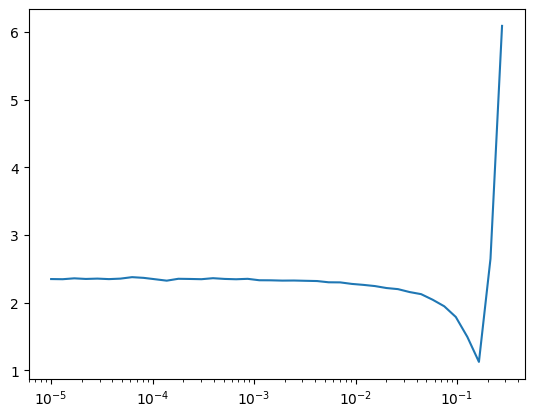

In [54]:
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

In [55]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.587,1.230,0,train
0.781,0.593,0,eval
0.817,0.492,1,train
0.830,0.457,1,eval
0.845,0.421,2,train
0.845,0.422,2,eval


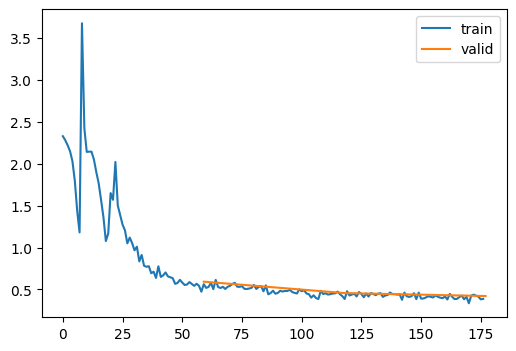

In [56]:
learn.fit(3)

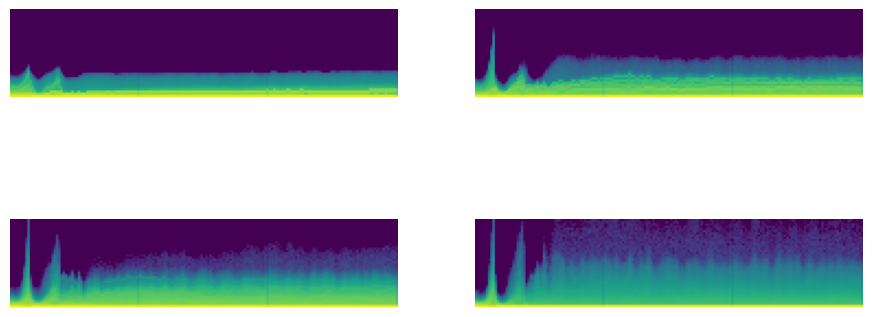

In [57]:
astats.color_dim()

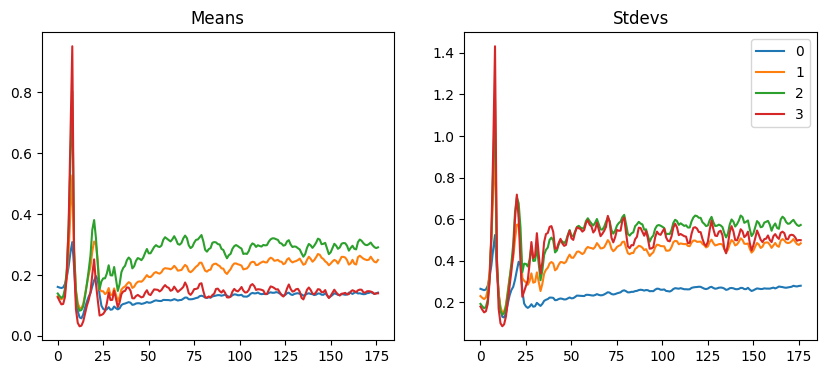

In [58]:
astats.plot_stats()

## Input normalization

In [59]:
xmean,xstd = xb.mean(), xb.std()
xmean,xstd

(tensor(0.29), tensor(0.35))

In [60]:
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [61]:
def _norm(b): return (b[0]-xmean)/xstd,b[1]
norm = BatchTransformCB(_norm)

accuracy,loss,epoch,train
0.549,1.394,0,train
0.769,0.605,0,eval
0.813,0.511,1,train
0.822,0.483,1,eval
0.843,0.428,2,train
0.835,0.448,2,eval


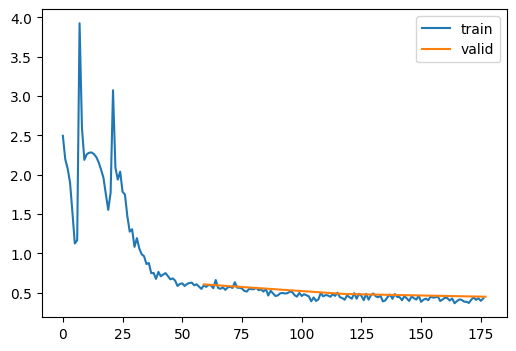

In [62]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm])
learn.fit(3)

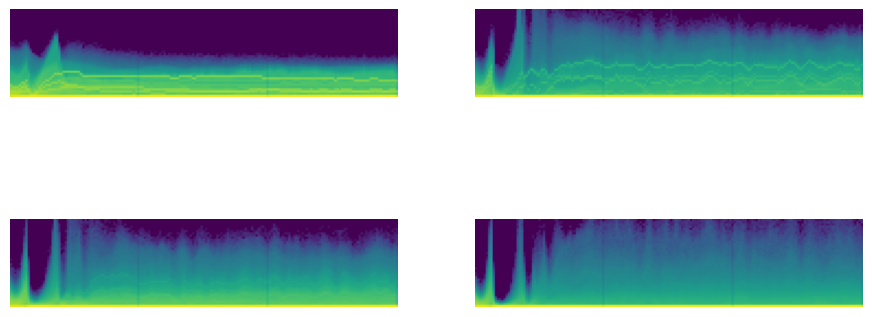

In [63]:
astats.color_dim()

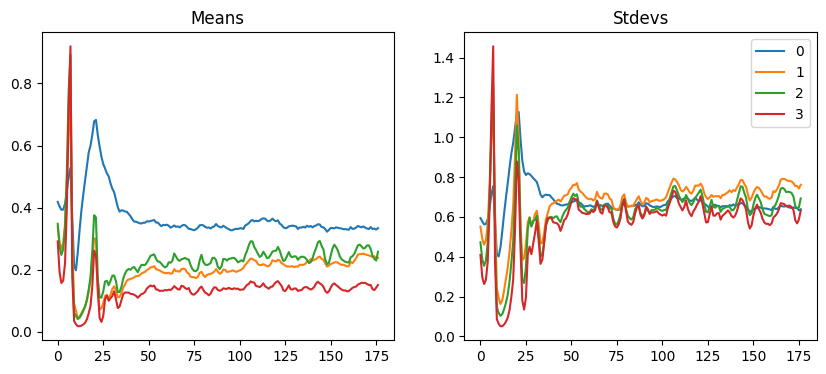

In [64]:
astats.plot_stats()

apply input normalization in the transform stage

In [65]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=2)
xb,yb = next(iter(dls.train))

In [66]:
xb.mean(),xb.std()

(tensor(0.01), tensor(1.00))

## General ReLU

In [67]:
class GeneralRelu(nn.Module):
  def __init__(self, leak=None, sub=None, maxv=None):
    super().__init__()
    self.leak,self.sub,self.maxv = leak,sub,maxv

  def forward(self, x):
    x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
    if self.sub is not None: x -= self.sub
    if self.maxv is not None: x.clamp_max_(self.maxv)
    return x

In [68]:
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

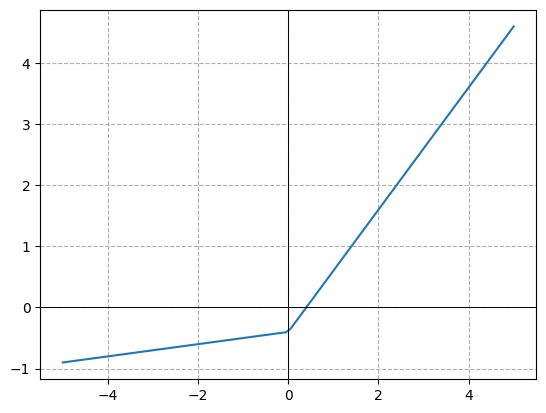

In [73]:
plot_func(GeneralRelu(leak=0.1, sub=0.4))

In [95]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [96]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None), nn.Flatten()).to(def_device)

In [97]:
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)

In [98]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [100]:
model = get_model(act_gr).apply(iw)

accuracy,loss,epoch,train
0.765,0.669,0,train
0.846,0.418,0,eval
0.867,0.363,1,train
0.865,0.370,1,eval
0.881,0.322,2,train
0.864,0.364,2,eval


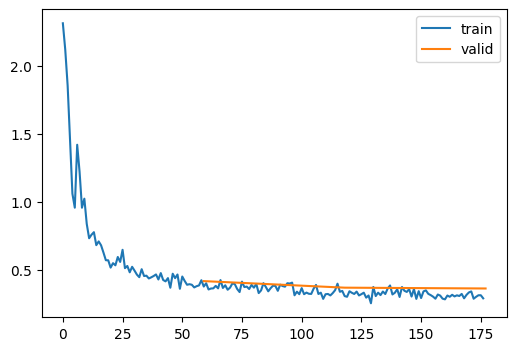

In [101]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

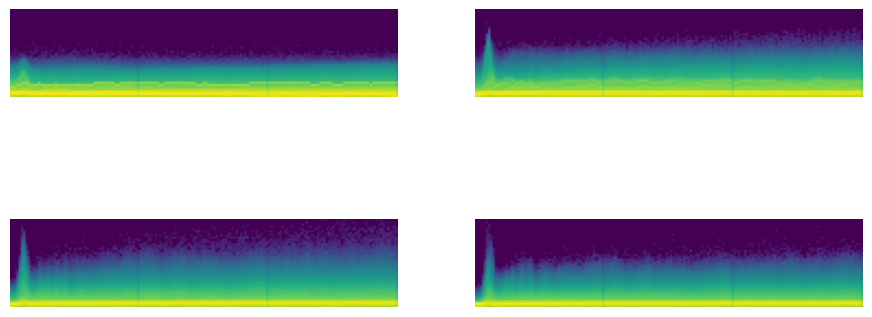

In [102]:
astats.color_dim()

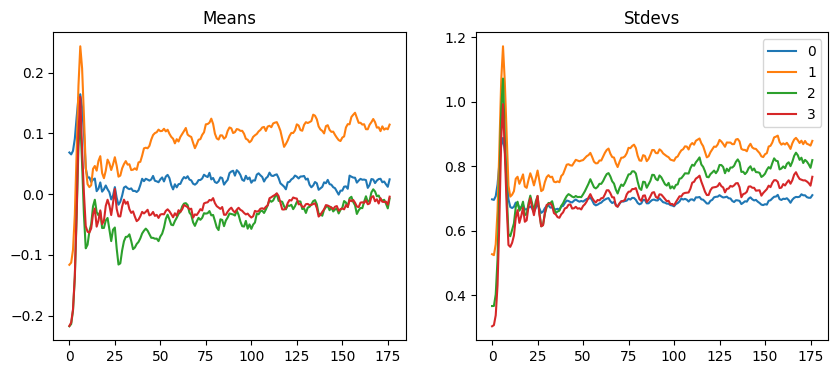

In [103]:
astats.plot_stats()

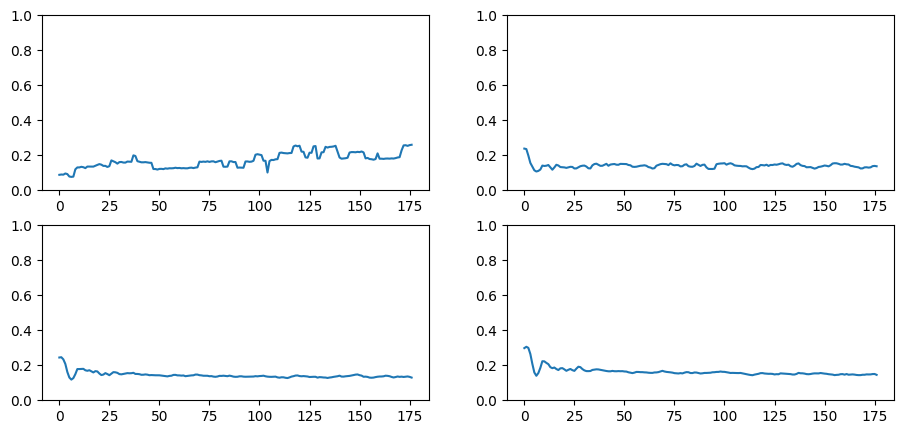

In [104]:
astats.dead_chart()

## LSUV

Layer-wise Sequential Unit-Variance (LSUV)

In [105]:
def _lsuv_stats(hook, mod, inp, outp):
    acts = to_cpu(outp)
    hook.mean = acts.mean()
    hook.std = acts.std()

def lsuv_init(model, m, m_in, xb):
    h = Hook(m, _lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
    h.remove()

In [106]:
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

In [107]:
for ms in zip(relus,convs): print(ms)

(GeneralRelu(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


In [108]:
for ms in zip(relus,convs): lsuv_init(model, *ms, xb.to(def_device))

accuracy,loss,epoch,train
0.772,0.650,0,train
0.835,0.454,0,eval
0.863,0.377,1,train
0.851,0.400,1,eval
0.876,0.337,2,train
0.861,0.376,2,eval


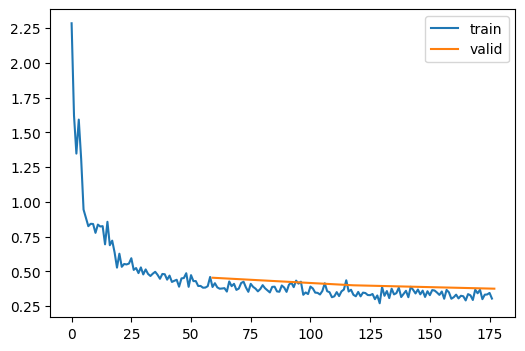

In [109]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

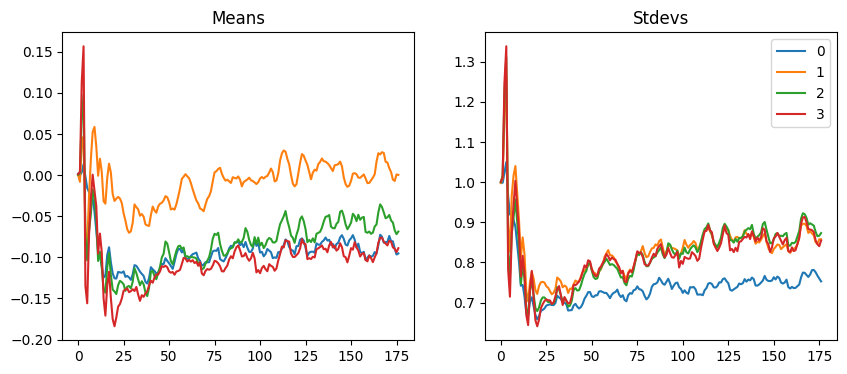

In [110]:
astats.plot_stats()

## Batch Normalization

Sergey Ioffe and Christian Szegedy released `"Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"` in 2015, saying:

- Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

Their proposal is:

- Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.

### LayerNorm

We'll start with layer normalization, a simpler technique.

In [114]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [115]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [116]:
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.781,0.605,0,train
0.846,0.422,0,eval
0.864,0.370,1,train
0.861,0.375,1,eval
0.883,0.320,2,train
0.868,0.365,2,eval


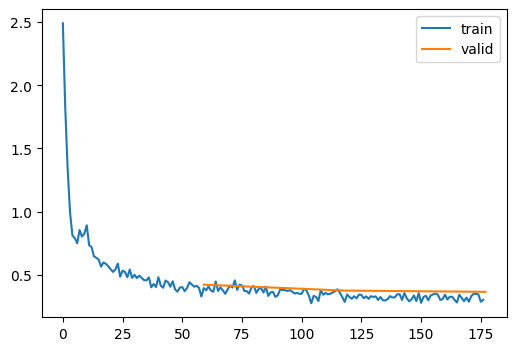

In [118]:
set_seed(42)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

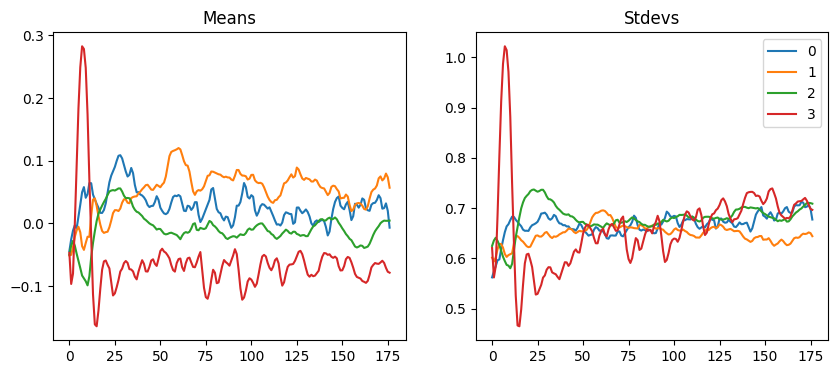

In [119]:
astats.plot_stats()

### BatchNorm

In [120]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v

    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

accuracy,loss,epoch,train
0.800,0.549,0,train
0.811,0.625,0,eval
0.874,0.341,1,train
0.866,0.371,1,eval
0.885,0.307,2,train
0.869,0.364,2,eval


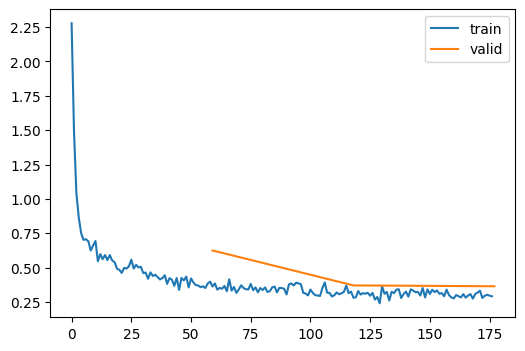

In [121]:
model = get_model(act_gr, norm=BatchNorm).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

## Towards 90%...

In [122]:
dls = DataLoaders.from_dd(tds, 256, num_workers=2)

accuracy,loss,epoch,train
0.837,0.450,0,train
0.867,0.359,0,eval
0.882,0.317,1,train
0.862,0.374,1,eval
0.897,0.281,2,train
0.887,0.312,2,eval


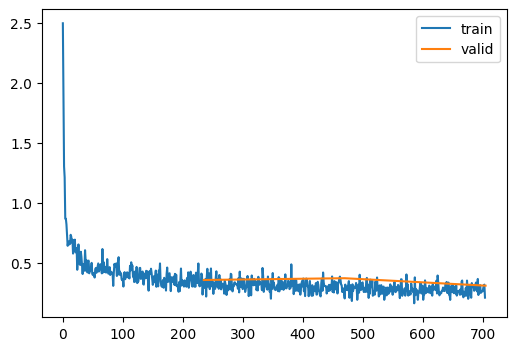

In [124]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

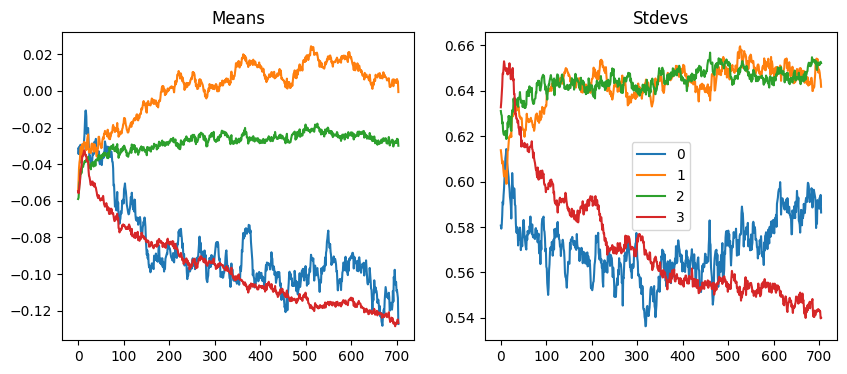

In [125]:
astats.plot_stats()

train more at lower learning rate

accuracy,loss,epoch,train
0.918,0.225,0,train
0.896,0.285,0,eval
0.922,0.212,1,train
0.900,0.280,1,eval


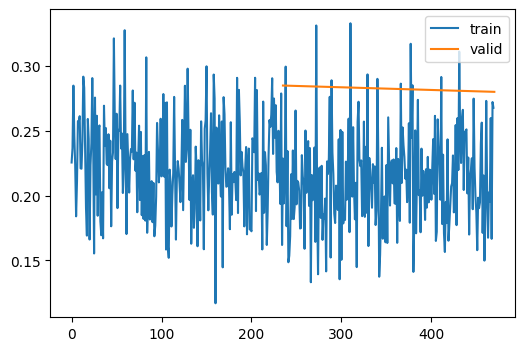

In [126]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)

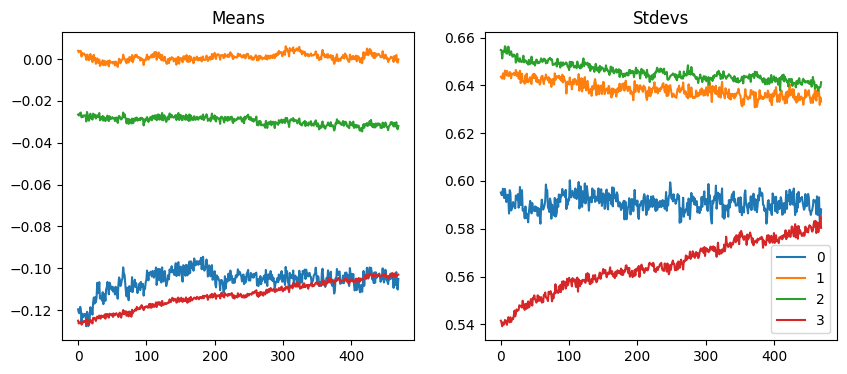

In [127]:
astats.plot_stats()